### Todo
Tujuan
- menjawab seluruh pertanyaan analisis atau bisnis yang sebelumnya telah dibuat; dan
- membuat visualisasi data untuk mempermudah penyampaian hasil analisis data.

Alur Latihan
- Persiapan.
- Membuat visualisasi data yang menjawab pertanyaan bisnis.

### Business Question
- Bagaimana performa penjualan dan revenue perusahaan dalam beberapa bulan terakhir?
- Produk apa yang paling banyak dan paling sedikit terjual?
- Bagaimana demografi pelanggan yang kita miliki?
- Kapan terakhir pelanggan melakukan transaksi?
- Seberapa sering seorang pelanggan melakukan pembelian dalam beberapa bulan terakhir?
- Berapa banyak uang yang dihabiskan pelanggan dalam beberapa bulan terakhir?

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate

#### Persiapan Data

In [40]:
customers_df = pd.read_csv("data\\clean\\customers_df_clean.csv")
orders_df = pd.read_csv("data\\clean\\orders_df_clean.csv")
product_df = pd.read_csv("data\\clean\\product_df_clean.csv")
sales_df = pd.read_csv("data\\clean\\sales_df_clean.csv")

In [41]:
datetime_columns = ["order_date", "delivery_date"]
for column in datetime_columns:
  orders_df[column] = pd.to_datetime(orders_df[column])

customer_id_in_orders_df =  orders_df.customer_id.tolist()
customers_df["status"] = customers_df["customer_id"].apply(
                          lambda x: "Active" 
                          if x in customer_id_in_orders_df 
                          else "Non Active")

orders_customers_df = pd.merge(
    left=orders_df,
    right=customers_df,
    how="left",
    left_on="customer_id",
    right_on="customer_id"
)

orders_customers_df["age_group"] = orders_customers_df.age.apply(
  lambda x: "Youth" 
  if x <= 24 
  else ("Seniors" if x > 64 else "Adults"))
orders_customers_df.groupby(by="age_group").order_id.nunique().sort_values(ascending=False)

sales_product_df = pd.merge(
    left=sales_df,
    right=product_df,
    how="left",
    left_on="product_id",
    right_on="product_id"
)
all_df = pd.merge(
    left=sales_product_df,
    right=orders_customers_df,
    how="left",
    left_on="order_id",
    right_on="order_id"
)

#### Bagaimana Performa Penjualan dan Revenue Perusahaan dalam Beberapa Bulan Terakhir?

In [42]:
# jumlah order dan total revenue yang diperoleh pada tiap bulannya.
monthly_orders_df = all_df.resample(rule='M', on='order_date').agg({
    "order_id": "nunique",
    "total_price": "sum"
})

monthly_orders_df.index = monthly_orders_df.index.strftime('%Y-%m')
monthly_orders_df = monthly_orders_df.reset_index()
monthly_orders_df.rename(columns={
    "order_id": "order_count",
    "total_price": "revenue"
}, inplace=True)

monthly_orders_df.head(2)

,order_date,order_count,revenue
0,2021-01,109,119333
1,2021-02,93,95080


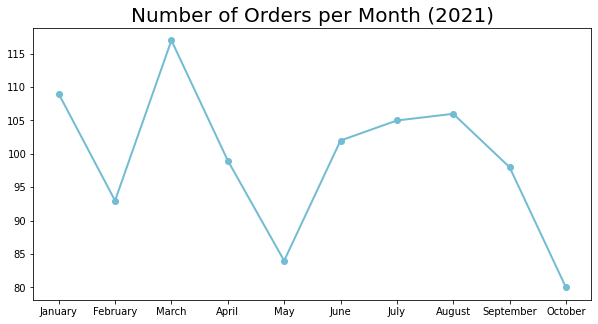

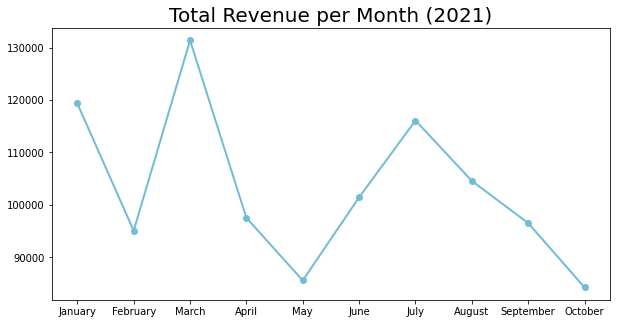

In [43]:
# line chart untuk memvisualkan informasi terkait jumlah order dan total revenue yang diperoleh tiap bulan. 
monthly_orders_df = all_df.resample(rule='M', on='order_date').agg({
    "order_id": "nunique",
    "total_price": "sum"
})
monthly_orders_df.index = monthly_orders_df.index.strftime('%B') #mengubah format order date menjadi nama bulan

monthly_orders_df = monthly_orders_df.reset_index()
monthly_orders_df.rename(columns={
    "order_id": "order_count",
    "total_price": "revenue"
}, inplace=True)

plt.figure(figsize=(10, 5)) 
plt.plot(monthly_orders_df["order_date"], monthly_orders_df["order_count"], marker='o', linewidth=2, color="#72BCD4") 
plt.title("Number of Orders per Month (2021)", loc="center", fontsize=20) 
plt.xticks(fontsize=10) 
plt.yticks(fontsize=10) 
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(
    monthly_orders_df["order_date"],
    monthly_orders_df["revenue"],
    marker='o', 
    linewidth=2,
    color="#72BCD4"
)
plt.title("Total Revenue per Month (2021)", loc="center", fontsize=20)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

#### Produk Apa yang Paling Banyak dan Paling Sedikit Terjual?

In [44]:
# informasi terkait jumlah penjualan tiap produk.
sum_order_items_df = all_df.groupby("product_name").quantity_x.sum().sort_values(ascending=False).reset_index()
sum_order_items_df.head()

,product_name,quantity_x
0,Denim,527
1,Joggers,334
2,Pleated,308
3,Casual Slim Fit,306
4,Shearling,302


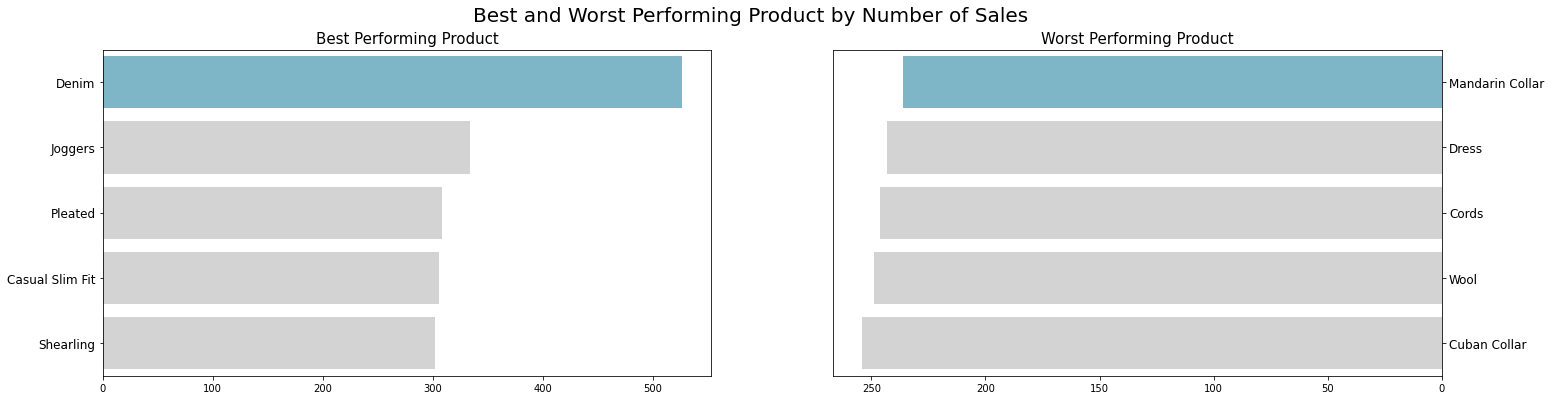

In [45]:
# bar chart mengidentifikasi produk dengan performa terbaik dan terburuk
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(24, 6))

colors = ["#72BCD4", "#D3D3D3", "#D3D3D3", "#D3D3D3", "#D3D3D3"]

sns.barplot(x="quantity_x", y="product_name", data=sum_order_items_df.head(5), palette=colors, ax=ax[0])
ax[0].set_ylabel(None)
ax[0].set_xlabel(None)
ax[0].set_title("Best Performing Product", loc="center", fontsize=15)
ax[0].tick_params(axis ='y', labelsize=12)

sns.barplot(x="quantity_x", y="product_name", data=sum_order_items_df.sort_values(by="quantity_x", ascending=True).head(5), palette=colors, ax=ax[1])
ax[1].set_ylabel(None)
ax[1].set_xlabel(None)
ax[1].invert_xaxis()
ax[1].yaxis.set_label_position("right")
ax[1].yaxis.tick_right()
ax[1].set_title("Worst Performing Product", loc="center", fontsize=15)
ax[1].tick_params(axis='y', labelsize=12)

plt.suptitle("Best and Worst Performing Product by Number of Sales", fontsize=20)
plt.show()

#### Bagaimana Demografi Pelanggan yang Kita Miliki?

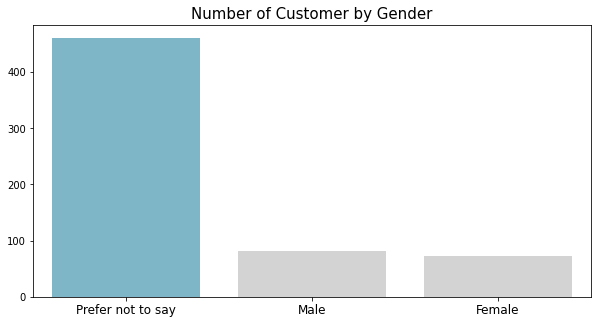

In [46]:
# informasi terkait jumlah pelanggan untuk demografi tertentu seperti gender, state, dll.

# Berdasarkan gender
bygender_df = all_df.groupby(by="gender").customer_id.nunique().reset_index()
bygender_df.rename(columns={
    "customer_id": "customer_count"
}, inplace=True)

plt.figure(figsize=(10, 5))

sns.barplot(
    y="customer_count", 
    x="gender",
    data=bygender_df.sort_values(by="customer_count", ascending=False),
    palette=colors
)
plt.title("Number of Customer by Gender", loc="center", fontsize=15)
plt.ylabel(None)
plt.xlabel(None)
plt.tick_params(axis='x', labelsize=12)
plt.show()

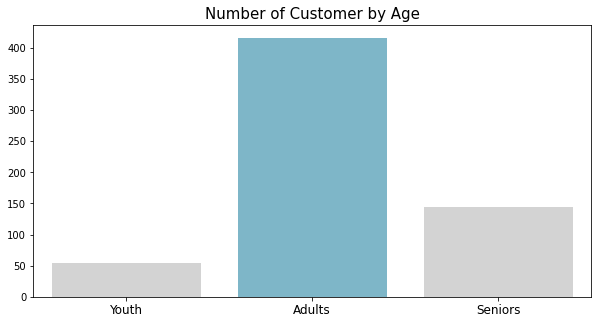

In [47]:
# Berdasarkan age
byage_df = all_df.groupby(by="age_group").customer_id.nunique().reset_index()
byage_df.rename(columns={
    "customer_id": "customer_count"
}, inplace=True)
byage_df
byage_df['age_group'] = pd.Categorical(byage_df['age_group'], ["Youth", "Adults", "Seniors"])
plt.figure(figsize=(10, 5))
colors_ = ["#D3D3D3", "#72BCD4", "#D3D3D3", "#D3D3D3", "#D3D3D3"]

sns.barplot(
    y="customer_count", 
    x="age_group",
    data=byage_df.sort_values(by="age_group", ascending=False),
    palette=colors_
)
plt.title("Number of Customer by Age", loc="center", fontsize=15)
plt.ylabel(None)
plt.xlabel(None)
plt.tick_params(axis='x', labelsize=12)
plt.show()

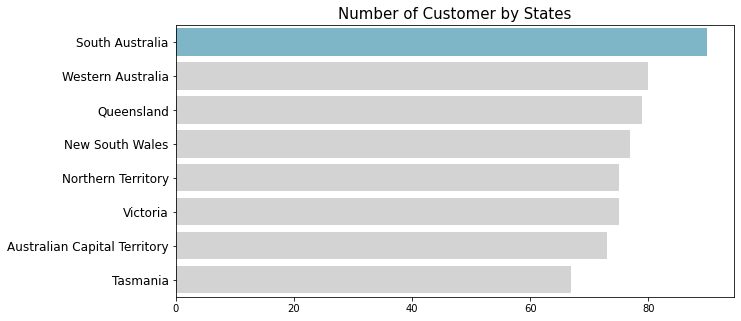

In [48]:
# Berdasarkan states
bystate_df = all_df.groupby(by="state").customer_id.nunique().reset_index()
bystate_df.rename(columns={
    "customer_id": "customer_count"
}, inplace=True)
bystate_df
plt.figure(figsize=(10, 5))
colors_ = ["#72BCD4", "#D3D3D3", "#D3D3D3", "#D3D3D3", "#D3D3D3", "#D3D3D3", "#D3D3D3", "#D3D3D3"]
sns.barplot(
    x="customer_count", 
    y="state",
    data=bystate_df.sort_values(by="customer_count", ascending=False),
    palette=colors_
)
plt.title("Number of Customer by States", loc="center", fontsize=15)
plt.ylabel(None)
plt.xlabel(None)
plt.tick_params(axis='y', labelsize=12)
plt.show()

#### RFM Analysis
Salah satu metode yang umum digunakan untuk melakukan segmentasi pelanggan (mengelompokkan pelanggan ke dalam beberapa kategori) berdasarkan tiga parameter, yaitu recency, frequency, dan monetary.

- Recency: parameter yang digunakan untuk melihat kapan terakhir seorang pelanggan melakukan transaksi.
- Frequency: parameter ini digunakan untuk mengidentifikasi seberapa sering seorang pelanggan melakukan transaksi.
- Monetary: parameter terakhir ini digunakan untuk mengidentifikasi seberapa besar revenue yang berasal dari pelanggan tersebut.

In [51]:
# informasi terkait recency, frequency, dan monetary.
rfm_df = all_df.groupby(by="customer_id", as_index=False).agg({
    "order_date": "max", # mengambil tanggal order terakhir
    "order_id": "nunique", # menghitung jumlah order
    "total_price": "sum" # menghitung jumlah revenue yang dihasilkan
})
rfm_df.columns = ["customer_id", "max_order_timestamp", "frequency", "monetary"]

# menghitung kapan terakhir pelanggan melakukan transaksi (hari)
rfm_df["max_order_timestamp"] = rfm_df["max_order_timestamp"].dt.date
recent_date = orders_df["order_date"].dt.date.max()
rfm_df["recency"] = rfm_df["max_order_timestamp"].apply(lambda x: (recent_date - x).days)

rfm_df.head()

,customer_id,max_order_timestamp,frequency,monetary,recency
0,1,2021-04-04,3,1641,203
1,7,2021-05-21,1,1017,156
2,10,2021-03-09,1,270,229
3,11,2021-05-28,1,382,149
4,12,2021-06-19,1,1551,127


In [52]:
rfm_df.drop("max_order_timestamp", axis=1, inplace=True)
rfm_df.head()

,customer_id,frequency,monetary,recency
0,1,3,1641,203
1,7,1,1017,156
2,10,1,270,229
3,11,1,382,149
4,12,1,1551,127


In [53]:
rfm_df.describe()

,customer_id,frequency,monetary,recency
count,616.00000,616.000000,616.000000,616.000000
mean,501.75974,1.612013,1675.000000,122.469156
std,286.16075,0.853754,1069.724092,84.326017
min,1.00000,1.000000,100.000000,0.000000
25%,259.50000,1.000000,878.250000,50.750000
50%,496.50000,1.000000,1439.000000,110.500000
75%,751.00000,2.000000,2165.000000,191.000000
max,1000.00000,6.000000,7632.000000,296.000000


In [54]:
rfm_df.sort_values(by="recency", ascending=True).head(5)

,customer_id,frequency,monetary,recency
241,401,4,3093,0
425,687,1,1122,0
426,690,3,3693,0
98,163,3,3494,1
250,415,2,2269,1


In [55]:
rfm_df.sort_values(by="frequency", ascending=False).head(5)

,customer_id,frequency,monetary,recency
350,571,6,6640,66
212,348,5,5119,24
346,566,5,5435,5
409,664,5,6341,20
166,282,5,7632,63


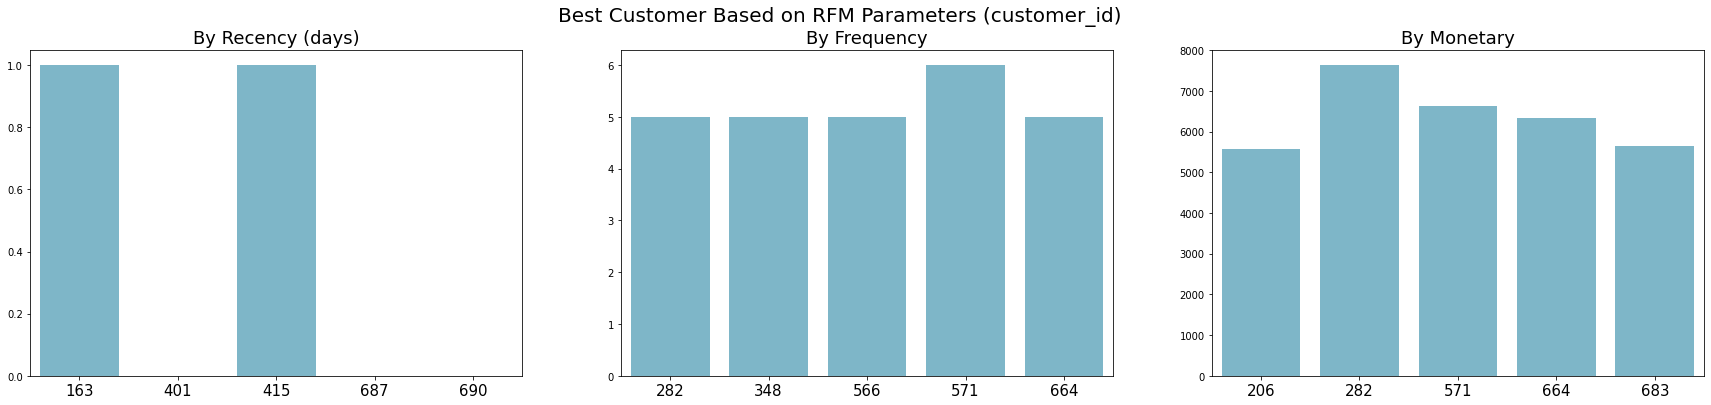

In [50]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(30, 6))

colors = ["#72BCD4", "#72BCD4", "#72BCD4", "#72BCD4", "#72BCD4"]

sns.barplot(y="recency", x="customer_id", data=rfm_df.sort_values(by="recency", ascending=True).head(5), palette=colors, ax=ax[0])
ax[0].set_ylabel(None)
ax[0].set_xlabel(None)
ax[0].set_title("By Recency (days)", loc="center", fontsize=18)
ax[0].tick_params(axis ='x', labelsize=15)

sns.barplot(y="frequency", x="customer_id", data=rfm_df.sort_values(by="frequency", ascending=False).head(5), palette=colors, ax=ax[1])
ax[1].set_ylabel(None)
ax[1].set_xlabel(None)
ax[1].set_title("By Frequency", loc="center", fontsize=18)
ax[1].tick_params(axis='x', labelsize=15)

sns.barplot(y="monetary", x="customer_id", data=rfm_df.sort_values(by="monetary", ascending=False).head(5), palette=colors, ax=ax[2])
ax[2].set_ylabel(None)
ax[2].set_xlabel(None)
ax[2].set_title("By Monetary", loc="center", fontsize=18)
ax[2].tick_params(axis='x', labelsize=15)

plt.suptitle("Best Customer Based on RFM Parameters (customer_id)", fontsize=20)
plt.show()

#### Mengurutkan customer berdasarkan recency, frequency, & monetary score

In [56]:
rfm_df['r_rank'] = rfm_df['recency'].rank(ascending=False)
rfm_df['f_rank'] = rfm_df['frequency'].rank(ascending=True)
rfm_df['m_rank'] = rfm_df['monetary'].rank(ascending=True)

rfm_df.head()

,customer_id,frequency,monetary,recency,r_rank,f_rank,m_rank
0,1,3,1641,203,133.0,560.0,351.0
1,7,1,1017,156,215.5,179.5,195.5
2,10,1,270,229,83.0,179.5,11.0
3,11,1,382,149,233.0,179.5,21.0
4,12,1,1551,127,267.5,179.5,330.0


In [57]:
# normalizing the rank of the customers
rfm_df['r_rank_norm'] = (rfm_df['r_rank']/rfm_df['r_rank'].max())*100
rfm_df['f_rank_norm'] = (rfm_df['f_rank']/rfm_df['f_rank'].max())*100
rfm_df['m_rank_norm'] = (rfm_df['m_rank']/rfm_df['m_rank'].max())*100
rfm_df.drop(columns=['r_rank', 'f_rank', 'm_rank'], inplace=True)
rfm_df.head()

,customer_id,frequency,monetary,recency,r_rank_norm,f_rank_norm,m_rank_norm
0,1,3,1641,203,21.626016,90.909091,56.980519
1,7,1,1017,156,35.040650,29.139610,31.737013
2,10,1,270,229,13.495935,29.139610,1.785714
3,11,1,382,149,37.886179,29.139610,3.409091
4,12,1,1551,127,43.495935,29.139610,53.571429


In [58]:
rfm_df['RFM_score'] = 0.15*rfm_df['r_rank_norm']+0.28 * \
    rfm_df['f_rank_norm']+0.57*rfm_df['m_rank_norm']
rfm_df['RFM_score'] *= 0.05
rfm_df = rfm_df.round(2)
rfm_df[['customer_id', 'RFM_score']].head(7)

,customer_id,RFM_score
0,1,3.06
1,7,1.58
2,10,0.56
3,11,0.79
4,12,2.26
5,13,1.14
6,15,3.84


#### Segmentasi customer berdasarkan RFM_score

In [59]:
rfm_df["customer_segment"] = np.where(
    rfm_df['RFM_score'] > 4.5, "Top customers", (np.where(
        rfm_df['RFM_score'] > 4, "High value customer",(np.where(
            rfm_df['RFM_score'] > 3, "Medium value customer", np.where(
                rfm_df['RFM_score'] > 1.6, 'Low value customers', 'lost customers'))))))

rfm_df[['customer_id', 'RFM_score', 'customer_segment']].head(20)

,customer_id,RFM_score,customer_segment
0,1,3.06,Medium value customer
1,7,1.58,lost customers
2,10,0.56,lost customers
3,11,0.79,lost customers
4,12,2.26,Low value customers
5,13,1.14,lost customers
6,15,3.84,Medium value customer
7,16,2.33,Low value customers
8,18,3.30,Medium value customer
9,19,1.68,Low value customers


In [60]:
customer_segment_df = rfm_df.groupby(by="customer_segment", as_index=False).customer_id.nunique()
customer_segment_df

,customer_segment,customer_id
0,High value customer,50
1,Low value customers,204
2,Medium value customer,137
3,Top customers,35
4,lost customers,190


In [61]:
customer_segment_df['customer_segment'] = pd.Categorical(customer_segment_df['customer_segment'], [
    "lost customers", "Low value customers", "Medium value customer",
    "High value customer", "Top customers"
])

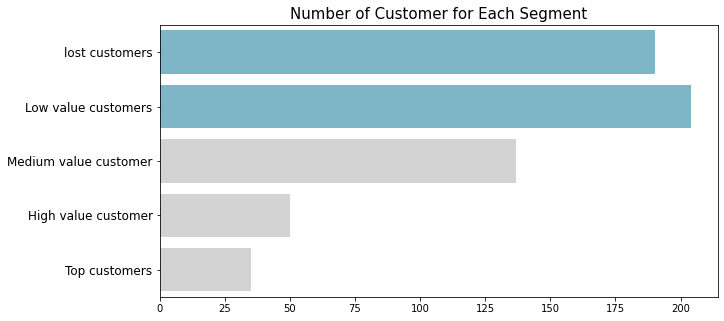

In [62]:
plt.figure(figsize=(10, 5))
colors_ = ["#72BCD4", "#72BCD4", "#D3D3D3", "#D3D3D3", "#D3D3D3"]

sns.barplot(
    x="customer_id", 
    y="customer_segment",
    data=customer_segment_df.sort_values(by="customer_segment", ascending=False),
    palette=colors_
)
plt.title("Number of Customer for Each Segment", loc="center", fontsize=15)
plt.ylabel(None)
plt.xlabel(None)
plt.tick_params(axis='y', labelsize=12)
plt.show()